![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# *Final Project: Contextual Bandits - Algorithm Analysis*

## Reinforcement Learning

#### Authors: **Timothy Cassel, Marvin Ernst, Oliver Tausendschön**

Date: July 2, 2025

Instructors: *Hamish Flynn and Vincent Adam*

In this notebook, we evaluate and analyze contextual bandit algorithms using the **Open Bandit Dataset (OBD)**. The main focus lies on implementing and benchmarking **Thompson Sampling (TS)** variants under realistic logged feedback conditions.

We perform the following:
- Implement **Thompson Sampling for linear bandits** using Bayesian linear regression
- Compare TS to **LinUCB** and **Random** policies
- Evaluate offline performance using:
  - **Inverse Propensity Scoring (IPS)**
  - **Doubly Robust (DR)** estimators
- Assess exploration behavior and learning stability
 
This notebook provides additional insights into the empirical behavior of Bayesian bandit strategies and whether **TS** can outperform **UCB** in sparse, realistic environments.

---

## 1. Setup and Imports

Importing the relevant libraries:

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from collections import defaultdict
import random
import os
from linucb import linucb_all

Set seeds for reproducibility:

In [20]:
np.random.seed(42)
random.seed(42)

## 2. Load Processed Data

(We have the preprocessed version in `processed_top3/`)

In [21]:
X_context = np.load("processed_top3/context_reduced.npy")
actions = np.load("processed_top3/actions.npy")
rewards = np.load("processed_top3/rewards.npy")
pscores = np.load("processed_top3/pscores.npy")
meta = np.genfromtxt("processed_top3/meta.txt", skip_header=1)

n_rounds, context_dim = X_context.shape
n_arms = len(np.unique(actions))

print(f"Context shape: {X_context.shape}, #Arms: {n_arms}")

Context shape: (53988, 12), #Arms: 3


## 3. Re-run LinUCB 

We use this for comparison to the TS version.

In [22]:
alpha = 1.0
A = [np.identity(X_context.shape[1]) for _ in range(n_arms)]
b = [np.zeros(X_context.shape[1]) for _ in range(n_arms)]

results = linucb_all(X_context, actions, rewards, A, b, alpha)

## 4. Thompson Sampling with Linear Models

We now implement **contextual Thompson Sampling (TS)** using a Bayesian linear regression formulation.

TS maintains a posterior distribution over the weight vector $\theta_a$ for each arm and samples from this distribution to select actions. In each round, it draws a sample $\tilde{\theta}_a$ for each arm, computes the estimated reward $\tilde{r}_a = x^\top \tilde{\theta}_a$, and selects the arm with the highest sampled reward.

This stochastic action selection naturally balances **exploration** (sampling new parameters) and **exploitation** (choosing high-reward arms).

We evaluate the standard TS algorithm with ridge priors:
- Prior: $\theta_a \sim \mathcal{N}(0, \lambda^{-1} I)$
- Posterior updated using ridge regression

After running the TS policy, we use the **Doubly Robust (DR)** estimator to compare its performance against LinUCB.

In [23]:
def ts_linear_all(contexts, actions, rewards, alpha=1.0, lambda_prior=1.0):
    n_rounds, context_dim = contexts.shape
    n_actions = len(np.unique(actions))

    A = [lambda_prior * np.identity(context_dim) for _ in range(n_actions)]
    b = [np.zeros(context_dim) for _ in range(n_actions)]

    chosen_actions = []
    theta_samples = []

    for t in range(n_rounds):
        x = contexts[t]
        sampled_thetas = []

        for a in range(n_actions):
            A_inv = np.linalg.inv(A[a])
            mu = A_inv @ b[a]
            cov = alpha**2 * A_inv  # scale variance by alpha
            theta_sample = np.random.multivariate_normal(mu, cov)
            sampled_thetas.append(theta_sample)

        rewards_hat = [x @ theta for theta in sampled_thetas]
        chosen_action = np.argmax(rewards_hat)

        # update only if action matches the logged one
        if chosen_action == actions[t]:
            A[chosen_action] += np.outer(x, x)
            b[chosen_action] += rewards[t] * x

        chosen_actions.append(chosen_action)
        theta_samples.append(sampled_thetas)

    return {
        "chosen_actions": chosen_actions,
        "theta_samples": theta_samples,
        "rewards": rewards,
        "true_actions": actions,
    }

## 5. Evaluate Thompson Sampling (DR)

We now evaluate the TS policy using the **Doubly Robust estimator**, consistent with our previous LinUCB analysis.

This enables fair comparison, particularly under sparse and partial feedback conditions.

In [24]:
ts_results = ts_linear_all(X_context, actions, rewards, alpha=1.0)

Ensuring reward_model and action_onehot are trained:

In [25]:
a_logged = np.array(actions)
r_logged = np.array(rewards)

action_onehot = OneHotEncoder(sparse_output=False)
a_logged_1hot = action_onehot.fit_transform(a_logged.reshape(-1, 1))

X_train = np.hstack([X_context, a_logged_1hot])
reward_model = RandomForestRegressor(n_estimators=100, random_state=42)
reward_model.fit(X_train, r_logged)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Predict rewards for TS actions:

In [26]:
a_ts = np.array(ts_results["chosen_actions"])
a_ts_1hot = action_onehot.transform(a_ts.reshape(-1, 1))
X_ts = np.hstack([X_context, a_ts_1hot])
r_hat_ts = reward_model.predict(X_ts)

DR correction:

In [27]:
matches_ts = a_ts == actions
correction_ts = np.zeros_like(rewards)
correction_ts[matches_ts] = (rewards[matches_ts] - r_hat_ts[matches_ts]) / pscores[matches_ts]
dr_estimates_ts = r_hat_ts + correction_ts
cumulative_dr_ts = np.cumsum(dr_estimates_ts)

**LinUCB evaluation**

In [28]:
a_linucb = np.array(results["chosen_actions"])
a_linucb_1hot = action_onehot.transform(a_linucb.reshape(-1, 1))
X_linucb = np.hstack([X_context, a_linucb_1hot])
r_hat_linucb = reward_model.predict(X_linucb)

matches_linucb = a_linucb == a_logged
correction_linucb = np.zeros_like(r_logged)
correction_linucb[matches_linucb] = (r_logged[matches_linucb] - r_hat_linucb[matches_linucb]) / pscores[matches_linucb]
dr_estimates = r_hat_linucb + correction_linucb
cumulative_dr = np.cumsum(dr_estimates)

For DM baseline:

In [30]:
a_logged_1hot = action_onehot.transform(a_logged.reshape(-1, 1))
X_dm = np.hstack([X_context, a_logged_1hot])
r_hat_dm = reward_model.predict(X_dm)
cumulative_dm_random = np.cumsum(r_hat_dm)

In [32]:
# Simulate a new random policy
np.random.seed(123)
random_actions = np.random.randint(0, n_arms, size=len(X_context))

# Predict rewards for the random policy
random_actions_1hot = action_onehot.transform(random_actions.reshape(-1, 1))
X_random = np.hstack([X_context, random_actions_1hot])
r_hat_random_eval = reward_model.predict(X_random)

# DR correction
matches_random = random_actions == a_logged
correction_random = np.zeros_like(r_logged)
correction_random[matches_random] = (r_logged[matches_random] - r_hat_random_eval[matches_random]) / pscores[matches_random]
dr_random_eval = r_hat_random_eval + correction_random
cumulative_random_eval = np.cumsum(dr_random_eval)

**Comparison**

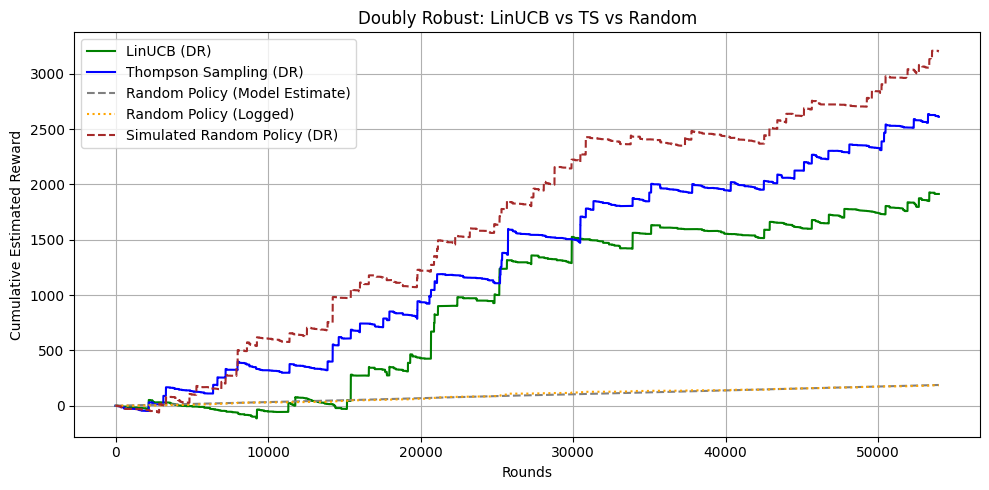

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(cumulative_dr, label="LinUCB (DR)", color="green")
plt.plot(cumulative_dr_ts, label="Thompson Sampling (DR)", color="blue")
plt.plot(cumulative_dm_random, label="Random Policy (Model Estimate)", linestyle="--", color="gray")
plt.plot(np.cumsum(rewards), label="Random Policy (Logged)", linestyle=":", color="orange")
plt.plot(cumulative_random_eval, label="Simulated Random Policy (DR)", linestyle="--", color="brown")
plt.title("Doubly Robust: LinUCB vs TS vs Random")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Estimated Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()